<a href="https://colab.research.google.com/github/Anidafio/4105_hw7/blob/main/hw7_p2bBatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from torchvision import datasets, transforms

cifar10 = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ]))

cifar10_val = datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ]))

cifar10

100%|██████████| 170498071/170498071 [00:01<00:00, 91904484.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=512,
                                           shuffle=True)

In [6]:
import torch.nn.functional as F

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            loss_train += loss.item()


        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = NetBatchNorm()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

Epoch: 1, Loss: 1.419284
Epoch: 2, Loss: 1.249311
Epoch: 3, Loss: 1.161937
Epoch: 4, Loss: 1.067431
Epoch: 5, Loss: 0.980470
Epoch: 6, Loss: 0.951502
Epoch: 7, Loss: 0.982844
Epoch: 8, Loss: 0.907271
Epoch: 9, Loss: 0.800910
Epoch: 10, Loss: 0.855939
Epoch: 11, Loss: 0.847947
Epoch: 12, Loss: 0.754809
Epoch: 13, Loss: 0.660019
Epoch: 14, Loss: 0.743483
Epoch: 15, Loss: 0.752130
Epoch: 16, Loss: 0.690430
Epoch: 17, Loss: 0.802754
Epoch: 18, Loss: 0.681045


KeyboardInterrupt: ignored

In [ ]:
import collections

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

predicted_labels = []
true_labels = []

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                predicted_labels.extend(predicted.numpy())
                true_labels.extend(labels.numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.82
Accuracy val: 0.72


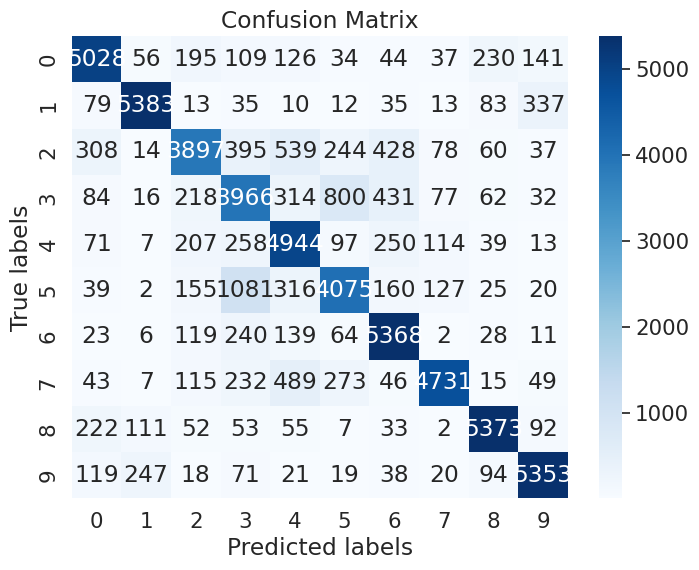

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      6000
           1       0.92      0.90      0.91      6000
           2       0.78      0.65      0.71      6000
           3       0.62      0.66      0.64      6000
           4       0.71      0.82      0.76      6000
           5       0.72      0.68      0.70      6000
           6       0.79      0.89      0.84      6000
           7       0.91      0.79      0.84      6000
           8       0.89      0.90      0.89      6000
           9       0.88      0.89      0.89      6000

    accuracy                           0.80     60000
   macro avg       0.81      0.80      0.80     60000
weighted avg       0.81      0.80      0.80     60000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust the font scale for better visualization

    # Create a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(true_labels), yticklabels=np.unique(predicted_labels))

    # Set labels, title, and display the plot
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix)

# Classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", class_report)